In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

The history saving thread hit an unexpected error (OperationalError('no such table: history',)).History will not be written to the database.


/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
with open(os.path.join(crd.rundir, 'lblnew.f'), 
          mode='r', encoding='utf-8') as f:
    c = f.read()

c = c.split('stop')[0]

print('\n\n'.join(get_input_params(c, sorted(innames()))))

dv = 0.001

klin =5e-25

nband = 80

ng =5

ng_adju = (/ -1 /) 

ng_refs = (/ 2 , 3 /) 

nref =2

nv = 1000

option_compute_btable =0

option_compute_ktable =0

option_klin =1

option_wgt_flux =2

option_wgt_k =1

p_refs = (/ 100 , 600 /) 

t_refs = (/ 250 , 250 /) 

tsfc =257

vstar = 720

data w_diffuse
     &     /1.55 , 1.6 , 1.66 , 1.66,
     &     1.8/

data wgt
     &     /0.5 , 0.5 , 0.6 , 0.7,
     &     0.9/

atmosphere_profiles/saw75.pro


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

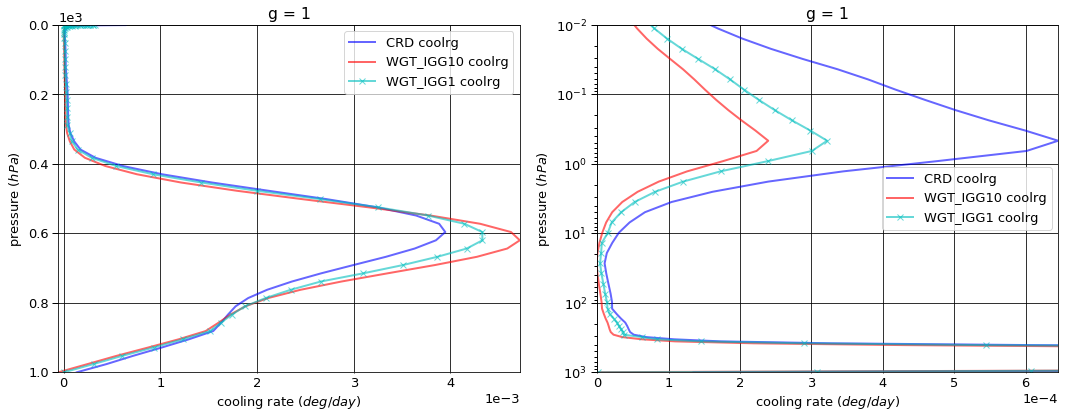

# Figure: cooling rate g-group 2

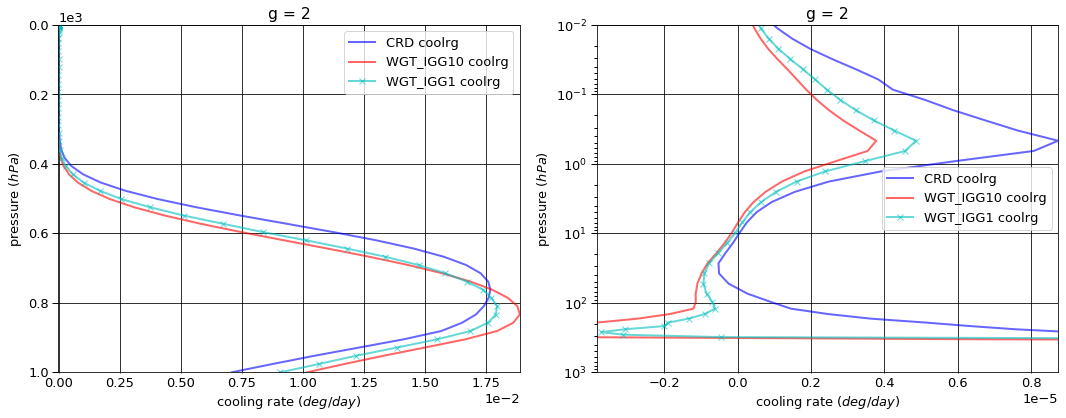

# Figure: cooling rate g-group 3

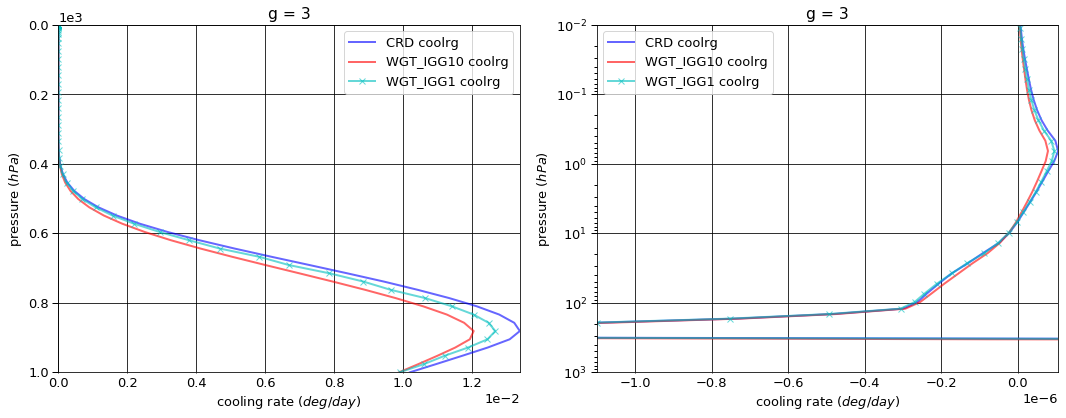

# Figure: cooling rate g-group 4

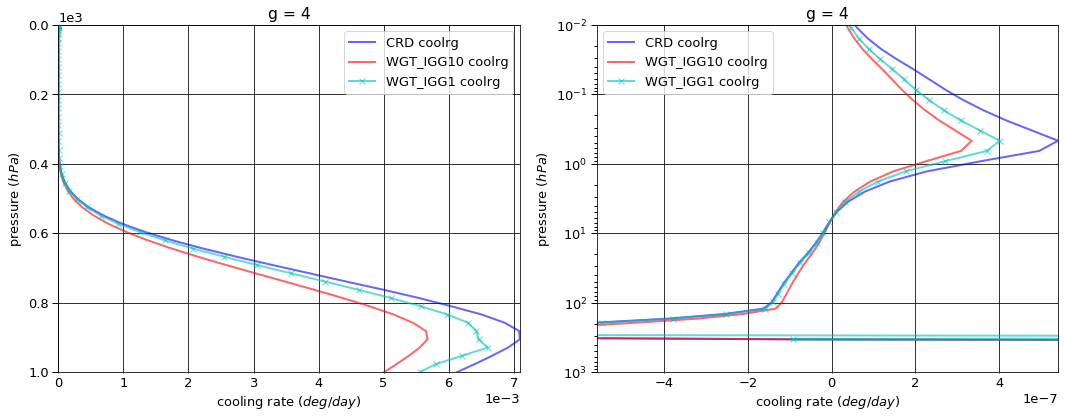

# Figure: cooling rate g-group 5

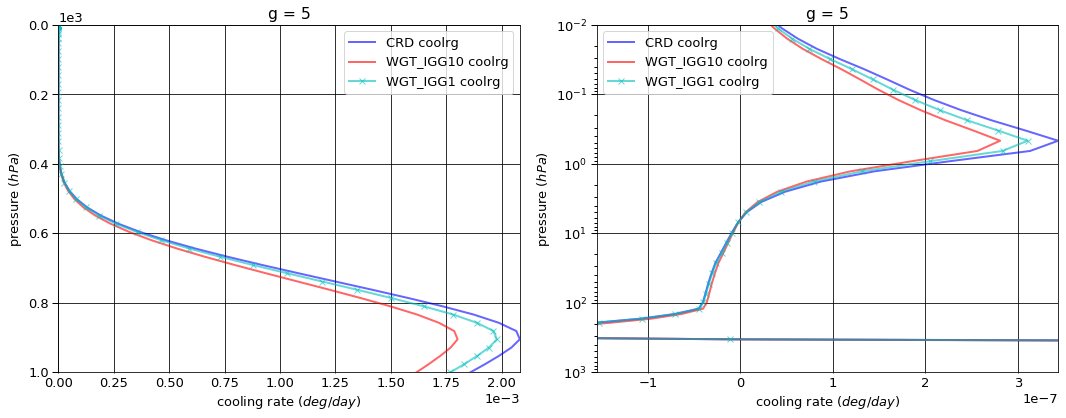

# Figure: cooling rate g-group total

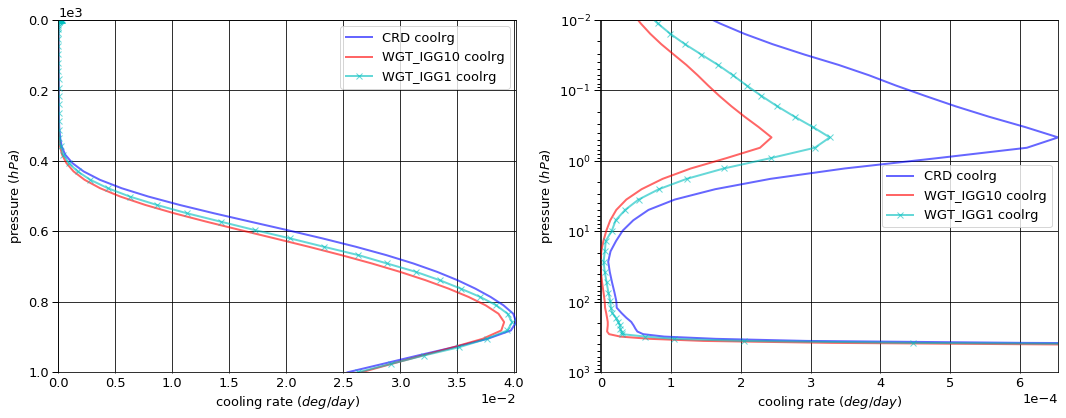

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.167757  0.000000 -0.167757
  1013.0   76    -0.206120  0.198707 -0.007414
2 0.0      1     -1.240963  0.000000 -1.240963
  1013.0   76    -1.313668  0.900881 -0.412787
3 0.0      1     -2.292002  0.000000 -2.292002
  1013.0   76    -2.308116  0.529122 -1.778994
4 0.0      1     -5.327901  0.000000 -5.327901
  1013.0   76    -5.334044  0.267177 -5.066867
5 0.0      1     -9.757941  0.000000 -9.757941
  1013.0   76    -9.759575  0.077166 -9.682409


WGT_IGG10


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.168770  0.000000 -0.168770
  1013.0   76    -0.206120  0.208563  0.002442
2 0.0      1     -1.268001  0.000000 -1.268001
  1013.0   76    -1.313668  0.842692 -0.470976
3 0.0      1     -2.295935  0.000000 -2.295935
  1013.0   76    -2.308116  0.463444 -1.844672
4 0.0      1     -5.329290  0.000000 -5.329290
  1013.0   76    -5.334044  0.212523 -5.121520
5 0.0      1     -9.758153  0.000000 -9.758153
  1013.0   76    -9.759575  0.066795 -9.692781


WGT_IGG1


flug      fldg     fnetg
g pressure level                              
1 0.0      1     -0.167430  0.000000 -0.167430
  1013.0   76    -0.206120  0.207102  0.000982
2 0.0      1     -1.261051  0.000000 -1.261051
  1013.0   76    -1.313668  0.840658 -0.473010
3 0.0      1     -2.293262  0.000000 -2.293262
  1013.0   76    -2.308116  0.498831 -1.809285
4 0.0      1     -5.328264  0.000000 -5.328264
  1013.0   76    -5.334044  0.246579 -5.087465
5 0.0      1     -9.757999  0.000000 -9.757999
  1013.0   76    -9.759575  0.073478 -9.686097


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -1.012470e-03  0.000000 -0.001012
  1013.0   76     0.000000e+00  0.009856  0.009856
2 0.0      1     -2.703740e-02  0.000000 -0.027037
  1013.0   76     0.000000e+00 -0.058189 -0.058189
3 0.0      1     -3.933100e-03  0.000000 -0.003933
  1013.0   76    -4.440892e-16 -0.065678 -0.065678
4 0.0      1     -1.388800e-03  0.000000 -0.001389
  1013.0   76     0.000000e+00 -0.054653 -0.054653
5 0.0      1     -2.121000e-04  0.000000 -0.000212
  1013.0   76    -1.776357e-15 -0.010372 -0.010372


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1      3.277900e-04  0.000000  0.000328
  1013.0   76     0.000000e+00  0.008396  0.008396
2 0.0      1     -2.008770e-02  0.000000 -0.020088
  1013.0   76     0.000000e+00 -0.060223 -0.060223
3 0.0      1     -1.260600e-03  0.000000 -0.001261
  1013.0   76    -4.440892e-16 -0.030291 -0.030291
4 0.0      1     -3.628000e-04  0.000000 -0.000363
  1013.0   76     0.000000e+00 -0.020598 -0.020598
5 0.0      1     -5.760000e-05  0.000000 -0.000058
  1013.0   76    -1.776357e-15 -0.003688 -0.003688

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer              
1 0.000312    1      1.216876e-05
  1001.112500 75     1.348609e-04
2 0.000312    1     -2.334325e-07
  1001.112500 75     7.098068e-03
3 0.000312    1     -1.933312e-09
  1001.112500 75     1.019148e-02
4 0.000312    1     -1.765198e-08
  1001.112500 75     6.122772e-03
5 0.000312    1     -1.330503e-08
  1001.112500 75     1.858979e-03


WGT_IGG10


coolrg
g pressure    layer              
1 0.000312    1     -2.019265e-06
  1001.112500 75    -5.572180e-05
2 0.000312    1     -1.038735e-07
  1001.112500 75     1.018336e-02
3 0.000312    1     -1.579072e-09
  1001.112500 75     9.875731e-03
4 0.000312    1     -1.127565e-08
  1001.112500 75     5.004128e-03
5 0.000312    1     -1.109553e-08
  1001.112500 75     1.615637e-03


WGT_IGG1


coolrg
g pressure    layer              
1 0.000312    1      1.957148e-06
  1001.112500 75     1.922625e-06
2 0.000312    1     -1.029159e-07
  1001.112500 75     9.093987e-03
3 0.000312    1     -1.807227e-09
  1001.112500 75     9.895877e-03
4 0.000312    1     -1.343712e-08
  1001.112500 75     5.553801e-03
5 0.000312    1     -1.215225e-08
  1001.112500 75     1.768937e-03


WGT_IGG10 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.418803e-05
  1001.112500 75    -1.905827e-04
2 0.000312    1      1.295590e-07
  1001.112500 75     3.085293e-03
3 0.000312    1      3.542405e-10
  1001.112500 75    -3.157518e-04
4 0.000312    1      6.376329e-09
  1001.112500 75    -1.118644e-03
5 0.000312    1      2.209500e-09
  1001.112500 75    -2.433422e-04


WGT_IGG1 - CRD


coolrg
g pressure    layer              
1 0.000312    1     -1.021161e-05
  1001.112500 75    -1.329383e-04
2 0.000312    1      1.305166e-07
  1001.112500 75     1.995919e-03
3 0.000312    1      1.260856e-10
  1001.112500 75    -2.956060e-04
4 0.000312    1      4.214861e-09
  1001.112500 75    -5.689717e-04
5 0.000312    1      1.152782e-09
  1001.112500 75    -9.004170e-05

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-18.786565,0.000000,-18.786565
1013.0,76,-18.921523,1.973052,-16.948470



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-18.820149,0.000000,-18.820149
1013.0,76,-18.921523,1.794016,-17.127507



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-18.808006,0.000000,-18.808006
1013.0,76,-18.921523,1.866648,-17.054875



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.033584,0.000000,-0.033584
1013.0,76,0.000000,-0.179036,-0.179036



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-0.021441,0.000000,-0.021441
1013.0,76,0.000000,-0.106404,-0.106404


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,0.000012
1001.112500,75,0.025406



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.000002
1001.112500,75,0.026623



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,0.000002
1001.112500,75,0.026315



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000014
1001.112500,75,0.001217



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,-0.000010
1001.112500,75,0.000908


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.010963,0.010888
2,0.069725,0.069403
3,0.122675,0.121927
4,0.282838,0.281821
5,0.513800,0.515961


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,1.395519e-22
2,3.410850e-24
3,3.161138e-24
4,5.001064e-25
5,3.765264e-26


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,1.395519e-22,NaN,0.010963,0.010888,0.010963,0.010888,100.0
2,3.410850e-24,0.024441,0.069725,0.069403,0.080687,0.080291,100.0
3,3.161138e-24,0.926789,0.122675,0.121927,0.203363,0.202218,600.0
4,5.001064e-25,0.158205,0.282838,0.281821,0.486200,0.484039,600.0
5,3.765264e-26,0.075289,0.513800,0.515961,1.000000,1.000000,600.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
